# Section 0: Imports and Dataframes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, coo_matrix, hstack
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import NMF, TruncatedSVD
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
import seaborn as sns
import joblib
sns.set(style="whitegrid")

# Section 1: Read dataframes

In [2]:
ratings_df = pd.read_csv("data/ml-latest-small/ratings.csv", usecols=["userId", "movieId", "rating"])
movies_df = pd.read_csv("data/ml-latest-small/movies.csv", usecols=["movieId", "title"])

df = ratings_df.merge(movies_df, on="movieId")

n_users = df.userId.nunique()
n_movies = df.movieId.nunique()

df.head(5)

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


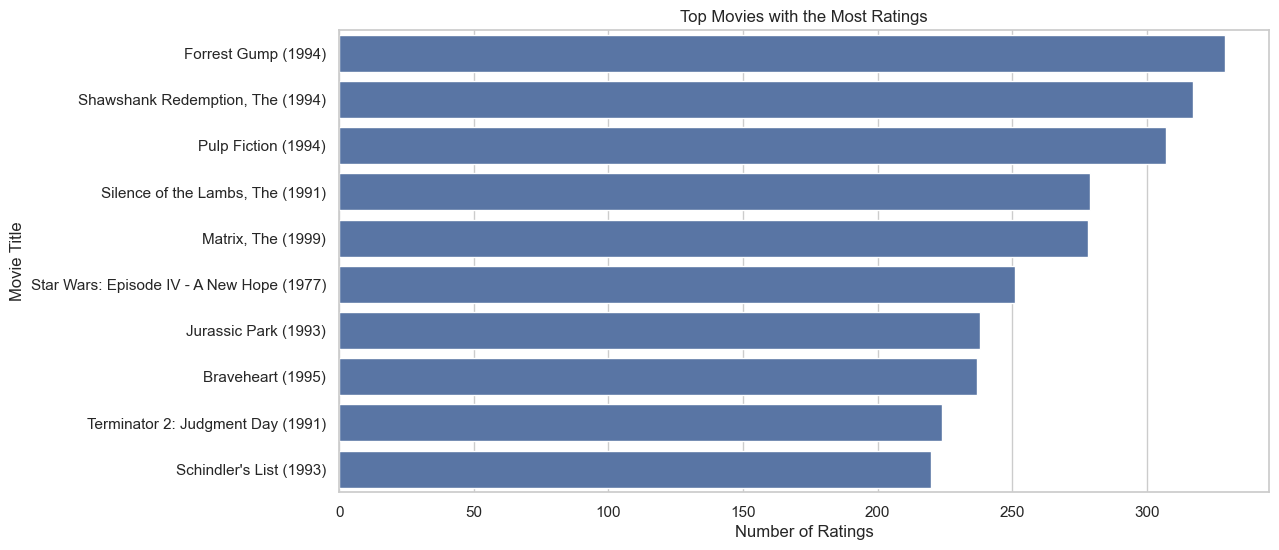

In [3]:
movie_ratings_count = df.groupby('title')['rating'].count().reset_index(name='ratings_count')

sorted_movies = movie_ratings_count.sort_values(by='ratings_count', ascending=False)

top_n_movies = sorted_movies.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='ratings_count', y='title', data=top_n_movies)
plt.title('Top Movies with the Most Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()

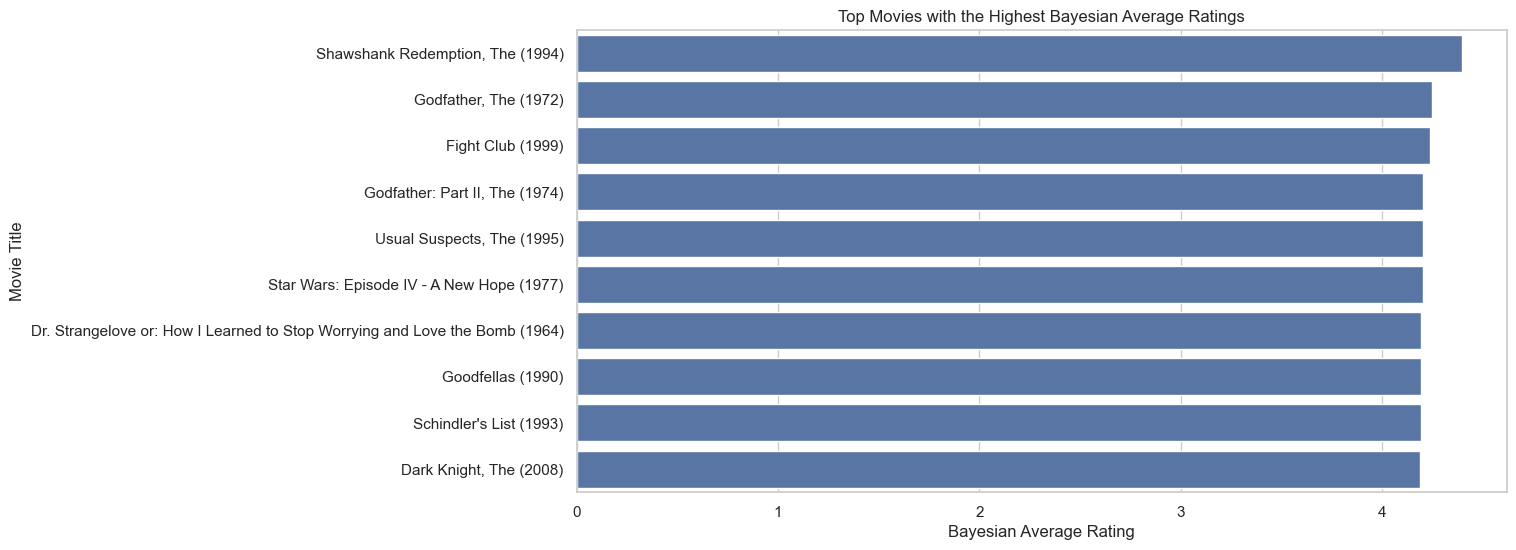

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

C = df['rating'].mean()
m = 10
movie_ratings = df.groupby('title')['rating'].agg(['count', 'mean']).reset_index()
bayesian_avg = (m * C + movie_ratings['count'] * movie_ratings['mean']) / (m + movie_ratings['count'])
sorted_movies_bayesian = pd.DataFrame({'title': movie_ratings['title'], 'bayesian_avg': bayesian_avg}).sort_values(by='bayesian_avg', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='bayesian_avg', y='title', data=sorted_movies_bayesian.head(10))
plt.title('Top Movies with the Highest Bayesian Average Ratings')
plt.xlabel('Bayesian Average Rating')
plt.ylabel('Movie Title')
plt.show()


# Section 1: Preprocessing

Label every user and every movie to have consistent indices. Construct the sparse matrix of the user-movie interactions.

In [5]:
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

df.userId = user_encoder.fit_transform(df.userId)
df.movieId = movie_encoder.fit_transform(df.movieId)
sparse_user_item = csr_matrix((df["rating"],
                               (df.userId.values, df.movieId.values)),
                               shape=(n_users, n_movies))

# Section 2: Recommendations

## 1) K Nearest Neighbors

In [6]:
item_matrix = sparse_user_item.T
K_NEIGHBORS = 10
knn = NearestNeighbors(n_neighbors=K_NEIGHBORS, algorithm="brute", metric="cosine")
knn.fit(item_matrix)

def find_similar_movies(movie_id):
    title = movies_df[movies_df["movieId"] == movie_id]["title"].to_string(index=False)
    print("Predicting neighbors close to:", title, "...")

    encoded_movie_id = movie_encoder.transform([movie_id])[0]

    _, neighbor_indices = knn.kneighbors(item_matrix[encoded_movie_id])

    similar_movies = movie_encoder.inverse_transform(neighbor_indices.flatten())
    similar_movies = similar_movies[similar_movies != movie_id]
    return similar_movies

PREDICT_MOVIE_IDX = 53125 # 64575 52281 31410 92637 106920
similar_movies_list = find_similar_movies(PREDICT_MOVIE_IDX)
movies_df[movies_df["movieId"].isin(similar_movies_list)][["title"]]

Predicting neighbors close to: Pirates of the Caribbean: At World's End (2007) ...


,title
4427,Pirates of the Caribbean: The Curse of the Bla...
5391,Ocean's Twelve (2004)
5735,Charlie and the Chocolate Factory (2005)
5978,"Brothers Grimm, The (2005)"
6221,Pirates of the Caribbean: Dead Man's Chest (2006)
6743,Iron Man (2008)
7214,Sherlock Holmes (2009)
7589,Thor (2011)
7608,Pirates of the Caribbean: On Stranger Tides (2...


## 2) Singular Value Decomposition

In [7]:
LATENT_FACTORS = 32 
U, Sigma, Vt = svds(sparse_user_item, k=LATENT_FACTORS, maxiter=1000)
Sigma = np.diag(Sigma)
predicted_ratings_svd = np.dot(np.dot(U, Sigma), Vt)
joblib.dump(predicted_ratings_svd, "svd_reconstructed")

rmse = mean_squared_error(sparse_user_item.data, predicted_ratings_svd[sparse_user_item.nonzero()], squared=False)
print("Reconstruction RMSE:", rmse)

def recommend_SVD(user_id, n_movies, predicted_ratings):
    user_id = user_encoder.transform([user_id])[0]
    user_ratings = predicted_ratings[user_id, :].copy()

    #Change the rating of the movies the user has
    #rated to zero so they aren't chosen by argsort
    user_rated_movies = sparse_user_item.nonzero()[1][sparse_user_item.nonzero()[0] == 0]
    user_ratings[user_rated_movies] = 0

    top_movie_indices = np.argsort(user_ratings)[::-1][:n_movies]

    top_movies = movie_encoder.inverse_transform(top_movie_indices)
    return movies_df[movies_df["movieId"].isin(top_movies)][["title"]]

Reconstruction RMSE: 2.1971624193423214


In [8]:
USER_ID = 1
N_MOVIES = 15
print(f"Top 10 recommended movies for user {USER_ID}:")
recommend_SVD(USER_ID, N_MOVIES, predicted_ratings_svd)

Top 10 recommended movies for user 1:


,title
507,Terminator 2: Judgment Day (1991)
659,"Godfather, The (1972)"
793,Die Hard (1988)
902,Aliens (1986)
922,"Godfather: Part II, The (1974)"
958,Stand by Me (1986)
1057,Star Trek II: The Wrath of Khan (1982)
1067,Jaws (1975)
1071,Mars Attacks! (1996)
1211,"Hunt for Red October, The (1990)"


Make predictions for user 1. We a little EDA we can see that user 1 has rated a lot of `Star Wars` movies with the rating 5. Therefore it is reasonable that our model predicts that the user would rate `Star Trek` movies positively. User 1 has also rated `Terminator` with a 5 star rating. `Terminator 2` is reasonable to appear in the results.

In [9]:
for item in df[(df.userId == 0) & (df.rating == 5.0)].title:
    print(item)

Seven (a.k.a. Se7en) (1995)
Usual Suspects, The (1995)
Bottle Rocket (1996)
Rob Roy (1995)
Canadian Bacon (1995)
Desperado (1995)
Billy Madison (1995)
Dumb & Dumber (Dumb and Dumber) (1994)
Star Wars: Episode IV - A New Hope (1977)
Tommy Boy (1995)
Jungle Book, The (1994)
Fugitive, The (1993)
Schindler's List (1993)
Tombstone (1993)
Pinocchio (1940)
Fargo (1996)
James and the Giant Peach (1996)
Wizard of Oz, The (1939)
Citizen Kane (1941)
Adventures of Robin Hood, The (1938)
Mr. Smith Goes to Washington (1939)
Winnie the Pooh and the Blustery Day (1968)
Three Caballeros, The (1945)
Sword in the Stone, The (1963)
Dumbo (1941)
Bedknobs and Broomsticks (1971)
Alice in Wonderland (1951)
Ghost and the Darkness, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Monty Python's Life of Brian (1979)
Reservoir Dogs (1992)
Basic Instinct (1992)
E.T. the Extra-Terrestrial (1982)
Monty Python and the Holy Grail (1975)
Star Wars: Episode V - The Empire Strikes Back (1980)
Princess Bride, The (19

## 3) Non-Negative Matrix Factorization

In [10]:
LATENT_FACTORS = 50
nmf_model = NMF(n_components=LATENT_FACTORS, init="random", random_state=42, max_iter=500)
W = nmf_model.fit_transform(sparse_user_item)
H = nmf_model.components_
predicted_ratings_nmf = np.dot(W, H)

def predict_NMF(user_id, n_movies, predicted_ratings):
    user_id = user_encoder.transform([user_id])[0]
    user_ratings = predicted_ratings[user_id, :].copy()

    #Change the rating of the movies the user has
    #rated to zero so they aren't chosen by argsort
    user_rated_movies = sparse_user_item.nonzero()[1][sparse_user_item.nonzero()[0] == 0]
    user_ratings[user_rated_movies] = 0

    top_movie_indices_nmf = np.argsort(user_ratings)[::-1][:n_movies]
    top_movies_nmf = movie_encoder.inverse_transform(top_movie_indices_nmf)
    return movies_df[movies_df["movieId"].isin(top_movies_nmf)][["title"]]

In [11]:
USER_ID = 1
N_MOVIES = 15
print(f"Top 10 recommended movies for user {USER_ID} using NMF:")
predict_NMF(USER_ID, N_MOVIES, predicted_ratings_nmf)

Top 10 recommended movies for user 1 using NMF:


,title
474,Blade Runner (1982)
507,Terminator 2: Judgment Day (1991)
659,"Godfather, The (1972)"
706,2001: A Space Odyssey (1968)
793,Die Hard (1988)
902,Aliens (1986)
1044,Star Trek: First Contact (1996)
1057,Star Trek II: The Wrath of Khan (1982)
1059,Star Trek IV: The Voyage Home (1986)
1067,Jaws (1975)


## 4) Truncated Singular Value Decomposition 

In [12]:
LATENT_FACTORS = 50
svd_model = TruncatedSVD(n_components=LATENT_FACTORS, random_state=42)
truncated_svd_matrix = svd_model.fit_transform(sparse_user_item)
predicted_ratings_svd = np.dot(truncated_svd_matrix, svd_model.components_)

def predict_trunc_SVD(user_id, n_movies, predicted_ratings):
    user_id = user_encoder.transform([user_id])[0]
    user_ratings = predicted_ratings[user_id, :].copy()

    #Change the rating of the movies the user has
    #rated to zero so they aren't chosen by argsort
    user_rated_movies = sparse_user_item.nonzero()[1][sparse_user_item.nonzero()[0] == 0]
    user_ratings[user_rated_movies] = 0

    top_movie_indices_svd = np.argsort(user_ratings)[::-1][:n_movies]
    top_movies_svd = movie_encoder.inverse_transform(top_movie_indices_svd)
    return movies_df[movies_df["movieId"].isin(top_movies_svd)][["title"]]

In [13]:
USER_ID = 15
N_MOVIES = 15
print(f"Top 10 recommended movies for user {USER_ID} using Truncated SVD:")
predict_trunc_SVD(USER_ID, N_MOVIES, predicted_ratings_svd)

Top 10 recommended movies for user 15 using Truncated SVD:


,title
277,"Shawshank Redemption, The (1994)"
507,Terminator 2: Judgment Day (1991)
659,"Godfather, The (1972)"
902,Aliens (1986)
2078,"Sixth Sense, The (1999)"
3194,Shrek (2001)
3638,"Lord of the Rings: The Fellowship of the Ring,..."
3640,"Beautiful Mind, A (2001)"
4137,"Lord of the Rings: The Two Towers, The (2002)"
4800,"Lord of the Rings: The Return of the King, The..."
